In [1]:
import os.path
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from ast import literal_eval
import matplotlib.pyplot as plt
import seaborn as sns
import toolsets.raw_data_scaffold as rds
import toolsets.T_rex as trx
import toolsets.spectra_operations as so
import toolsets.spectra_plotter as plotter
import toolsets.denoising_related_functions as drf
import re
import chemparse
from pubchempy import Compound, get_compounds
from toolsets.search import quick_search_values, quick_search_sorted, string_search, search_feature
import itertools
from rdkit import Chem
import toolsets.denoising_related_functions as drf
import toolsets.chem_utils as cu
from molmass import Formula
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
master_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/denoising_data'

In [2]:
def precursor_percent(msms, pmz):
    mass, intensity= so.break_spectra(msms)
    index_start = np.searchsorted(mass, pmz-1.6,side = 'left')
    mass_parent = mass[index_start:]
    intensity_parent = intensity[index_start:]
    mass_frag = mass[0:index_start]
    intensity_frag = intensity[0:index_start]
    return(np.sum(intensity_parent)/np.sum(intensity))
def determine_charge_state(adduct):

    if adduct[0]=='[':
        charge_state = re.split(r'\[|]', adduct)[-1]
        adduct_part = re.split(r'\[|]', adduct)[1]
        ind = re.split(r'(\+|-)', adduct_part)
    else:
        charge_state = adduct[-1]
        adduct_part = adduct
        ind = re.split(r'(\+|-)', adduct_part)
    if charge_state[-1]=='+':
        coef = 1
    elif charge_state[-1]=='-':
        coef = -1
    else:
        return(np.NAN)
    if len(charge_state)>1:
        charge_state = int(charge_state[0:-1])*coef
    else:
        charge_state = 1*coef
    return(int(charge_state))

In [3]:
nist_pos = pd.read_csv('/Users/fanzhoukong/Documents/GitHub/Libgen_data/curated_library/csv/pos_orbi_nist_sorted.csv')

In [4]:
nist_pos = nist_pos.dropna(subset='SMILES')

In [9]:
msms_d_frag = []
msms_d_nl = []
eis_frag = []
eis_nl = []
included_idx = []
for index, row in tqdm(nist_pos.iterrows(), total = len(nist_pos)):
    try:
        calculated_pmz = cu.calculate_precursormz(row['SMILES'], row['Precursor_type'], if_smiles=True)
    except:
        calculated_pmz = np.NAN
    if calculated_pmz == calculated_pmz and abs(calculated_pmz-row['PrecursorMZ'])<0.005:
        if precursor_percent(row['spectrum'], row['PrecursorMZ'])<0.9 and abs(determine_charge_state(row['Precursor_type']))==1:
            try:
                denoised_nl = drf.spectra_denoising(row['spectrum'], row['SMILES'], adduct = row['Precursor_type'], mass_tolerance=0.005)
                denoised_frag = drf.spectra_denoising_frag(row['spectrum'], row['SMILES'], adduct = row['Precursor_type'], mass_tolerance=0.005)
                msms_d_frag.append(denoised_frag[0])
                eis_frag.append(denoised_frag[1])
                msms_d_nl.append(denoised_nl[0])
                eis_nl.append(denoised_nl[1])
                included_idx.append(index)
            except:
                pass
    # if index == 199:
    #     break

100%|██████████| 1254241/1254241 [13:06:52<00:00, 26.57it/s]   


In [12]:
nist_denoised = nist_pos.loc[included_idx]

In [13]:
nist_denoised['msms_d_frag']=msms_d_frag
nist_denoised['msms_d_nl']=msms_d_nl
nist_denoised['eis_frag']=eis_frag
nist_denoised['eis_nl']=eis_nl

In [15]:
nist_denoised['eis_nl'].describe()

count    1.100989e+06
mean     9.775759e-01
std      8.206357e-02
min      0.000000e+00
25%      9.915923e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: eis_nl, dtype: float64

In [16]:
nist_denoised['eis_frag'].describe()

count    1.100989e+06
mean     9.884890e-01
std      5.143819e-02
min      0.000000e+00
25%      9.971294e-01
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: eis_frag, dtype: float64

In [17]:
from scipy import stats

In [21]:
nist_denoised.to_csv(os.path.join(master_dir, 'nist_denoised.csv'), index = False)

In [26]:
np.sum(np.array(eis_nl)>0.9)

1043804

In [29]:
(np.sum(np.array(eis_nl)>0.9))/len(eis_nl)

0.948060334844399

In [32]:
nist_denoised[nist_denoised['eis_frag']<0.9]

,Unnamed: 0,library_idx,spectrum,Name,Ion_mode,Precursor_type,PrecursorMZ,SMILES,Comments,msms_d_frag,msms_d_nl,eis_frag,eis_nl
253,282207,282207,55.0177\t6.6\n56.9646\t18.1\n57.0333\t3.0\n67....,4-Hydroxyhexenal,P,[M+H-H2O]+,97.0648,CCC(O)C=CC=O,NIST Mass Spectrometry Data Center,55.0177\t6.6\n57.0333\t3.0\n67.0541\t8.8\n69.0...,55.0177\t6.6\n57.0333\t3.0\n67.0541\t8.8\n69.0...,0.571011,0.571011
255,282209,282209,53.0384\t1.3\n55.0177\t28.9\n55.0541\t4.2\n55....,4-Hydroxyhexenal,P,[M+H-H2O]+,97.0648,CCC(O)C=CC=O,NIST Mass Spectrometry Data Center,53.0384\t1.3\n55.0177\t28.9\n55.0541\t4.2\n57....,53.0384\t1.3\n55.0177\t28.9\n55.0541\t4.2\n57....,0.827635,0.827635
315,333440,333440,50.0151\t1.3\n51.0231\t17.8\n52.0183\t3.5\n53....,"5-Cyclopropyl-1,3,4-thiadiazol-2-ylamine",P,[M+H-CH2N2]+,100.0215,Nc1nnc(C2CC2)s1,NIST Mass Spectrometry Data Center,50.0151\t1.3\n51.0231\t17.8\n52.0183\t3.5\n53....,50.0151\t1.3\n51.0231\t17.8\n52.0183\t3.5\n53....,0.863057,0.863057
318,333439,333439,51.0231\t3.5\n52.0182\t1.1\n54.034\t2.1\n56.04...,"5-Cyclopropyl-1,3,4-thiadiazol-2-ylamine",P,[M+H-CH2N2]+,100.0215,Nc1nnc(C2CC2)s1,NIST Mass Spectrometry Data Center,51.0231\t3.5\n52.0182\t1.1\n54.034\t2.1\n56.04...,51.0231\t3.5\n52.0182\t1.1\n54.034\t2.1\n56.04...,0.881543,0.881543
330,333438,333438,54.034\t2.7\n56.0496\t19.7\n57.053\t1.1\n58.99...,"5-Cyclopropyl-1,3,4-thiadiazol-2-ylamine",P,[M+H-CH2N2]+,100.0215,Nc1nnc(C2CC2)s1,NIST Mass Spectrometry Data Center,54.034\t2.7\n56.0496\t19.7\n58.9951\t3.8\n59.9...,54.034\t2.7\n56.0496\t19.7\n58.9951\t3.8\n59.9...,0.898556,0.899406
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283489,587776,587776,171.0652\t7.6\n187.06\t3.9\n205.0706\t15.7\n22...,6-O-Acetyl-.beta.-D-glucopyranosyl-(1->3)-[.be...,P,[M+NH4]+,1670.7432,CC(=O)OCC1OC(OC2C(O)C(OC3C(OC(=O)C45CCC(C)(C)C...,NIST Mass Spectrometry Data Center,171.0652\t7.6\n187.06\t3.9\n205.0706\t15.7\n22...,273.0969\t3.0\n295.1025\t1.3\n297.0968\t3.2\n3...,0.888786,0.956476
1283495,589427,589427,165.0907\t2.1\n291.1224\t2.8\n309.1331\t17.9\n...,"Olean-12-en-28-oic acid, 16-hydroxy-3-[(O-pent...",P,[M+NH4]+,1670.8160,C=CC(C)(O)CCC=C(C)C(=O)OC1C(O)C(CO)OC(OC(=O)C2...,NIST Mass Spectrometry Data Center,165.0907\t2.1\n291.1224\t2.8\n309.1331\t17.9\n...,291.1224\t2.8\n309.1331\t17.9\n313.1645\t4.6\n...,0.843212,0.960482
1283496,589426,589426,459.1866\t2.6\n591.2286\t2.9\n605.2442\t4.4\n6...,"Olean-12-en-28-oic acid, 16-hydroxy-3-[(O-pent...",P,[M+NH4]+,1670.8160,C=CC(C)(O)CCC=C(C)C(=O)OC1C(O)C(CO)OC(OC(=O)C2...,NIST Mass Spectrometry Data Center,459.1866\t2.6\n591.2286\t2.9\n605.2442\t4.4\n6...,459.1866\t2.6\n591.2286\t2.9\n605.2442\t4.4\n6...,0.327093,0.938908
1283497,589425,589425,1353.688\t1.2\n1371.6923\t2.2\n1389.7085\t4.5\...,"Olean-12-en-28-oic acid, 16-hydroxy-3-[(O-pent...",P,[M+NH4]+,1670.8160,C=CC(C)(O)CCC=C(C)C(=O)OC1C(O)C(CO)OC(OC(=O)C2...,NIST Mass Spectrometry Data Center,1353.688\t1.2\n1371.6923\t2.2\n1389.7085\t4.5\...,1353.688\t1.2\n1371.6923\t2.2\n1389.7085\t4.5\...,0.040020,0.924519


In [33]:
row = nist_denoised[nist_denoised['eis_frag']<0.9].iloc[0]

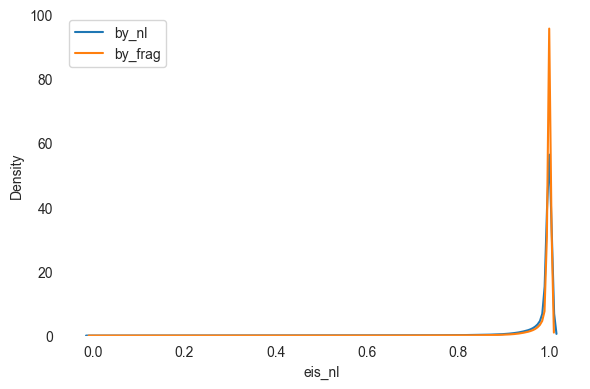

In [14]:
fig = plt.figure(figsize = (6, 4))#43
ax = fig.add_subplot()
#

sns.kdeplot(nist_denoised['eis_nl'], label= 'by_nl' )
sns.kdeplot(nist_denoised['eis_frag'], label= 'by_frag' )
# plt.xlim(0, 100)
# ax.set_xlabel('Explained intensity (%)',size = 16)
# ax.set_ylabel('Density', size = 16)
# sns.lineplot(x = range(1,14), y = ns_means)
# sns.histplot(library_bad_quality['normalized_entropy'], label = 'low_quality')
# plt.vlines(x = 0.8, ymin=0, ymax=250, color = 'red')
plt.grid(False)
ax.set_facecolor("white")
plt.legend(facecolor='white')
# plt.legend()
fig.tight_layout()
# plt.savefig(os.path.join(figs_dir, 'ei_across_concs.png'))